In [41]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from utils import display_hist

### Visualize the dataset:

In [2]:
ROOT = './data'
TRAIN_PATH = os.path.join(ROOT, 'train')
VALID_PATH = os.path.join(ROOT, 'valid')

In [3]:
classes = os.listdir(TRAIN_PATH)
classes

['cat', 'dog']

In [4]:
ex_path = os.path.join(TRAIN_PATH, classes[0])
ex_img = os.listdir(ex_path)[0]
ex_img = os.path.join(ex_path, ex_img)
ex_img = cv2.imread(ex_img)
print(ex_img.shape)

(374, 500, 3)


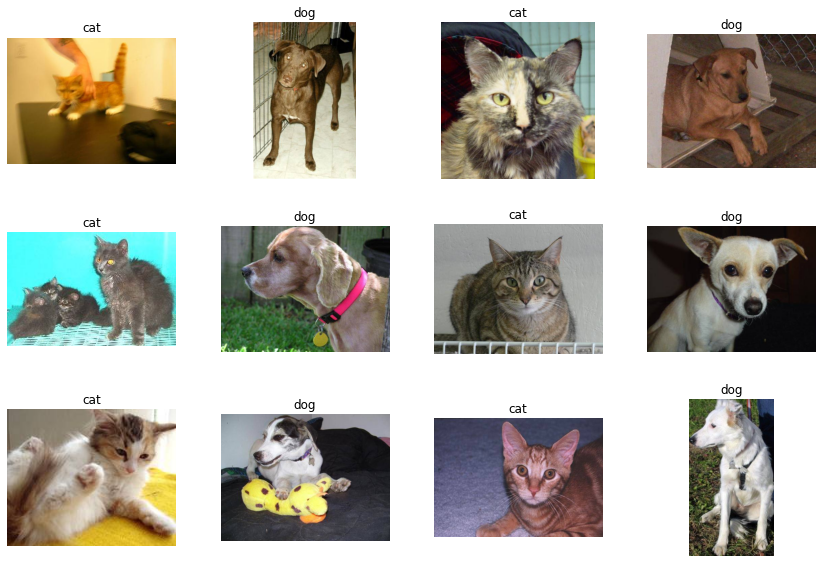

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
fig.tight_layout()
for i, ax in enumerate(axes.flat):
    class_ = classes[i % 2]
    class__folder = os.path.join(TRAIN_PATH, class_)
    file = os.listdir(class__folder)[i]
    path = os.path.join(class__folder, file)
    img = cv2.imread(path)
    ax.imshow(img[:,:,::-1])
    ax.set_title(class_)
    ax.axis('off')

### Create tf Dataset

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_PATH,
                                                                    image_size=(IMG_SIZE, IMG_SIZE),
                                                                    batch_size=BATCH_SIZE,
                                                                    shuffle=True,)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(VALID_PATH,
                                                                    image_size=(IMG_SIZE, IMG_SIZE),
                                                                    batch_size=BATCH_SIZE,
                                                                    shuffle=True,)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [7]:
AUTOTUNE =  tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
train_dataset.take(1).as_numpy_iterator().next()[0].shape

(32, 224, 224, 3)

### Data Augmentation

In [9]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

### Model

In [36]:
from models.mobilenet import MobileNet, preprocess_input

base_model = MobileNet(input_shape=(IMG_SIZE, IMG_SIZE, 3), n_classes=2, alpha=1.0, dropout=0.25).get_model()

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
outputs = base_model(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.multiply_5 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                          

### Callbacks

Early stop and checkpoints

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('weights/mobilenet.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

LR reduce:

In [38]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                               patience=5, 
                                                               verbose=1, 
                                                               factor=0.5, 
                                                               min_lr=1e-5)
callbacks = [learning_rate_reduction, checkpoint]          

### Compile and train model

In [39]:
# optim = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
history = model.fit(train_dataset, epochs=5, validation_data=valid_dataset, callbacks=callbacks) 

Epoch 1/5
63/63 [==============================] - 26s 290ms/step - loss: 0.7584 - accuracy: 0.5000 - val_loss: 0.7289 - val_accuracy: 0.5023 - lr: 0.0010
Epoch 2/5
63/63 [==============================] - 17s 267ms/step - loss: 0.7167 - accuracy: 0.4995 - val_loss: 0.9238 - val_accuracy: 0.4992 - lr: 0.0010
Epoch 3/5
63/63 [==============================] - 17s 273ms/step - loss: 0.7149 - accuracy: 0.4963 - val_loss: 0.8209 - val_accuracy: 0.5008 - lr: 0.0010
Epoch 4/5
63/63 [==============================] - 18s 275ms/step - loss: 0.6864 - accuracy: 0.5048 - val_loss: 1.2529 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/5
63/63 [==============================] - 17s 270ms/step - loss: 0.6570 - accuracy: 0.4992 - val_loss: 1.0964 - val_accuracy: 0.5008 - lr: 0.0010


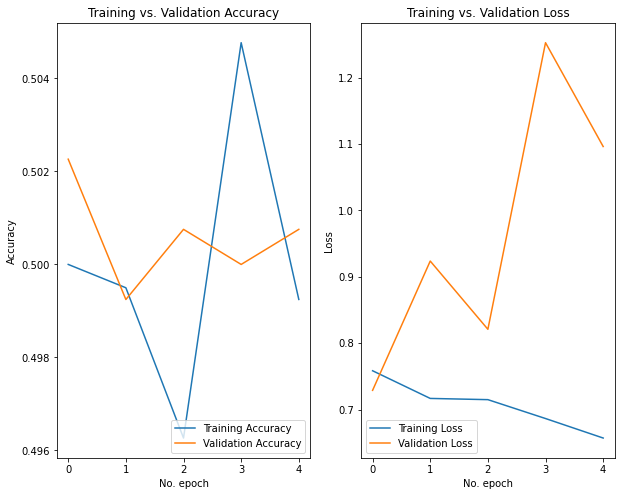

In [43]:
display_hist(history)